## Individual Household Electric Power Consumption

The goal of this notebook is to use forecasting techniques on the Individual Household Electric Power Consumption Dataset.

Infos on the dataset:

Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.

Dataset source: https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).
Notes: 

1.(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.


2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.



## Data Exploration 
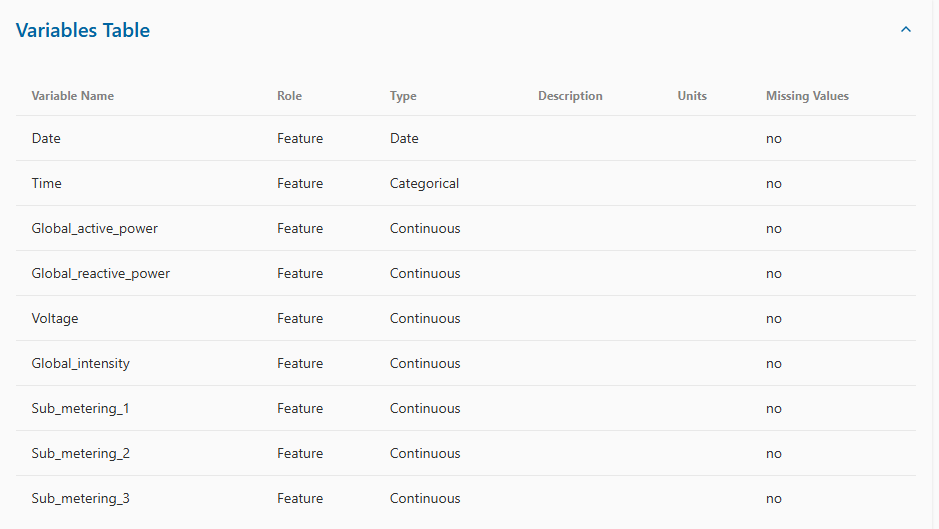

In [2]:
# Importing the dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# Load dataset
file_path = "household_power_consumption/household_power_consumption.txt"  # Update with your actual path
df = pd.read_csv(file_path, sep=';', low_memory=False, na_values=['?'])

In [4]:
#  Convert Date & Time to Datetime Format
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df = df.drop(columns=['Date', 'Time'])  # Drop original columns
df = df.set_index('datetime')  # Set datetime as index
df = df.astype(float)  # Convert all columns to float

In [ ]:
df_resampled = df.resample('W').mean()  # Aggregates to weekly average
df_resampled = df_resampled.interpolate() # interpolate missing values

In [7]:
import matplotlib.pyplot as plt

def plot_aggregated_time_series(df, freq, value_column='Global_active_power'):
    """
    Aggregates time series data and plots it based on the given frequency.

    Parameters:
    - df: Pandas DataFrame with a DateTime index.
    - freq: Resampling frequency ('H', 'D', 'W', 'M', 'Y' for hourly, daily, weekly, monthly, yearly).
    - value_column: The column to aggregate and plot.

    Returns:
    - A time series plot of the aggregated data.
    """
    # Define frequency labels for the title
    freq_labels = {
        'h': 'Hourly',
        'd': 'Daily',
        'W': 'Weekly',
        'ME': 'Monthly',
        'YE': 'Yearly'
    }

    # if freq not in freq_labels:
    #     raise ValueError("Invalid frequency. Use 'h' (hourly), 'D' (daily), 'W' (weekly), 'ME' (monthly), or 'YE' (yearly).")

    # Resample (aggregate) data
    df_temp = df.resample(freq)[value_column].mean()

    # Plot the resampled time series
    plt.figure(figsize=(12, 5))
    plt.plot(df_temp, label=f'{freq_labels[freq]} Aggregation')
    # plt.plot(df_resampled.index, df_resampled['Global_active_power'], label=f'{freq_labels[freq]} Aggregation')
    plt.xlabel('Time')
    plt.ylabel(value_column)
    plt.title(f'{freq_labels[freq]} Aggregated Time Series')
    plt.legend()
    plt.grid(True)
    plt.show()


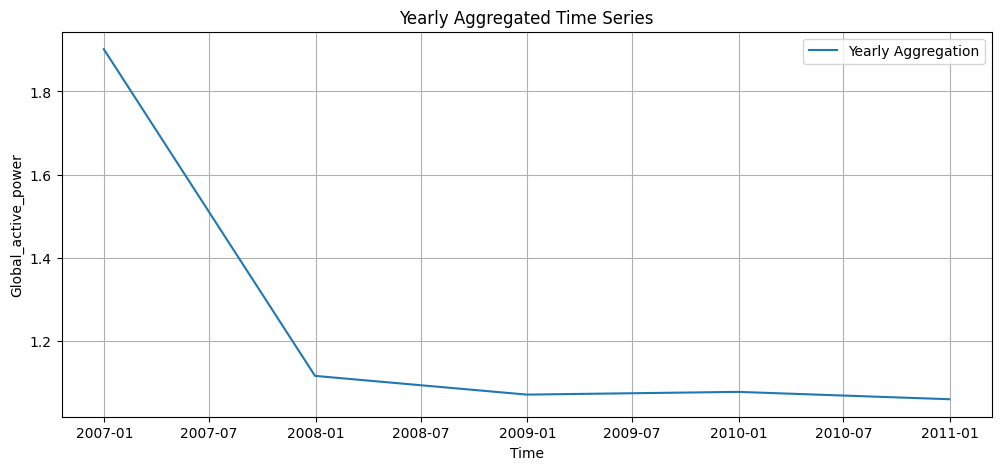

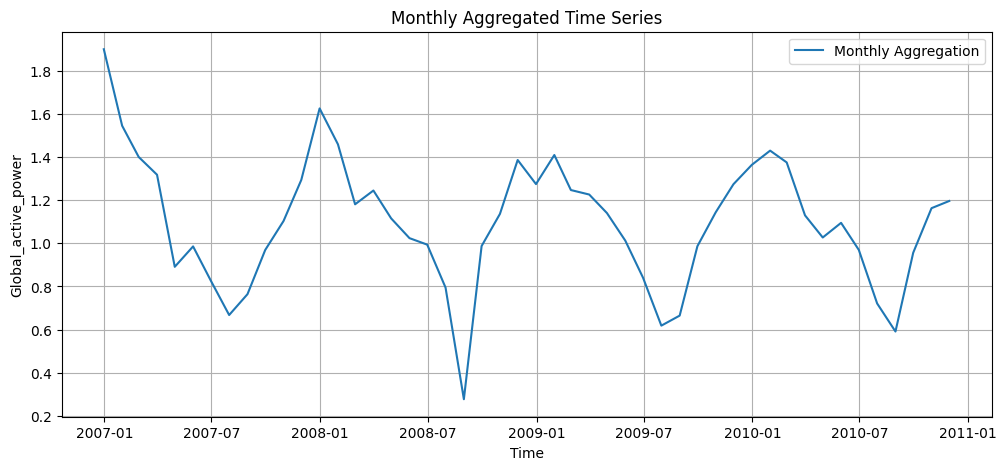

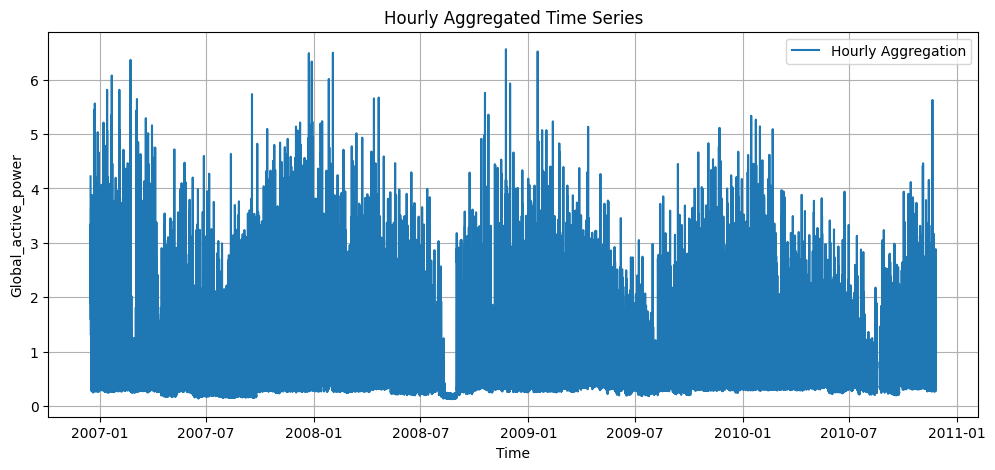

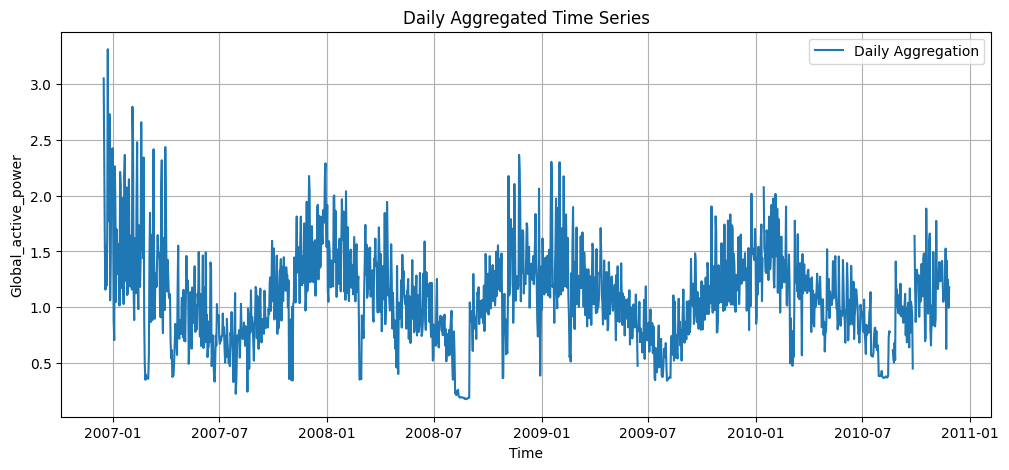

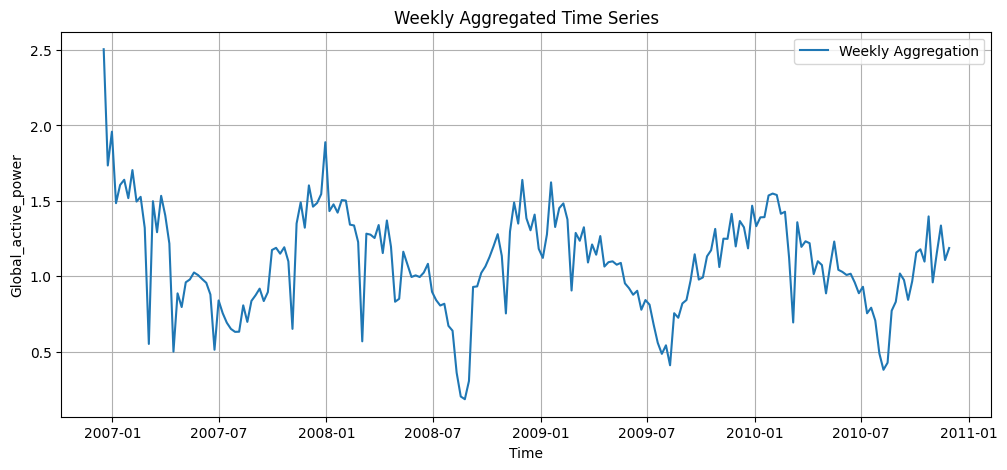

In [8]:
plot_aggregated_time_series(df, 'YE')  # Yearly
plot_aggregated_time_series(df, 'ME')  # Monthly
plot_aggregated_time_series(df, 'h')  # Hourly
plot_aggregated_time_series(df, 'd')  # Daily
plot_aggregated_time_series(df, 'W')  # Weekly

## Analysis of the power consumption

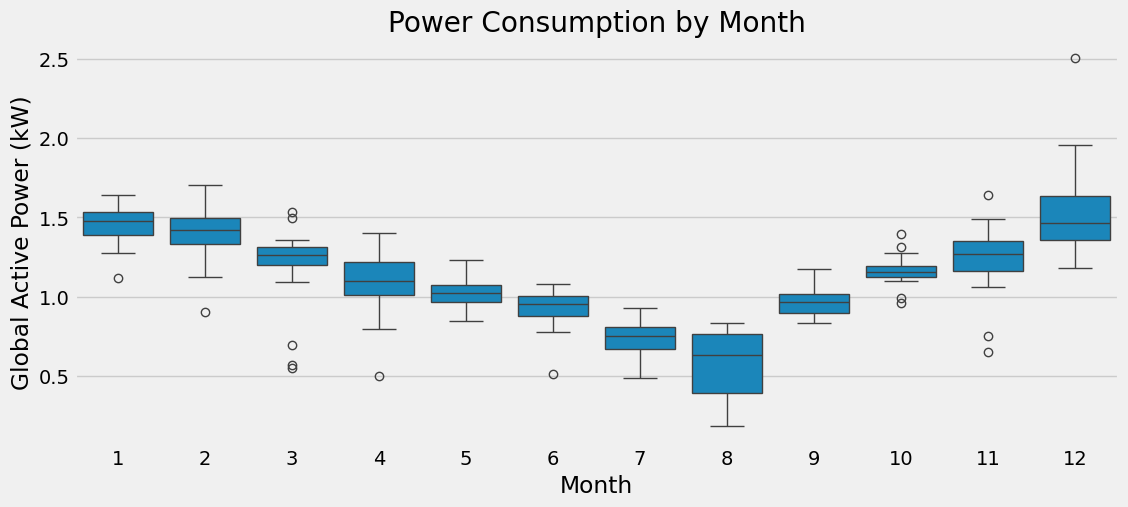

In [9]:
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Ensure datetime index
df_viz = df_resampled.reset_index()
df_viz['Year'] = df_viz['datetime'].dt.year
df_viz['Month'] = df_viz['datetime'].dt.month
df_viz['Day'] = df_viz['datetime'].dt.day
df_viz['Hour'] = df_viz['datetime'].dt.hour

plt.figure(figsize=(12, 5))
sns.boxplot(x='Month', y='Global_active_power', data=df_viz)
plt.xlabel('Month')
plt.ylabel('Global Active Power (kW)')
plt.title('Power Consumption by Month')
plt.show()


The boxplot shows that the power consumption is highest during winter (months 01-02 and 12), and lowest during summer (august). This makes sense due to the high usage of heating devices during winter and perhaps because the users go on vacation in july-august (which is typical in Paris).  


In the following analysis, I proceed with the weekly aggregated time series.

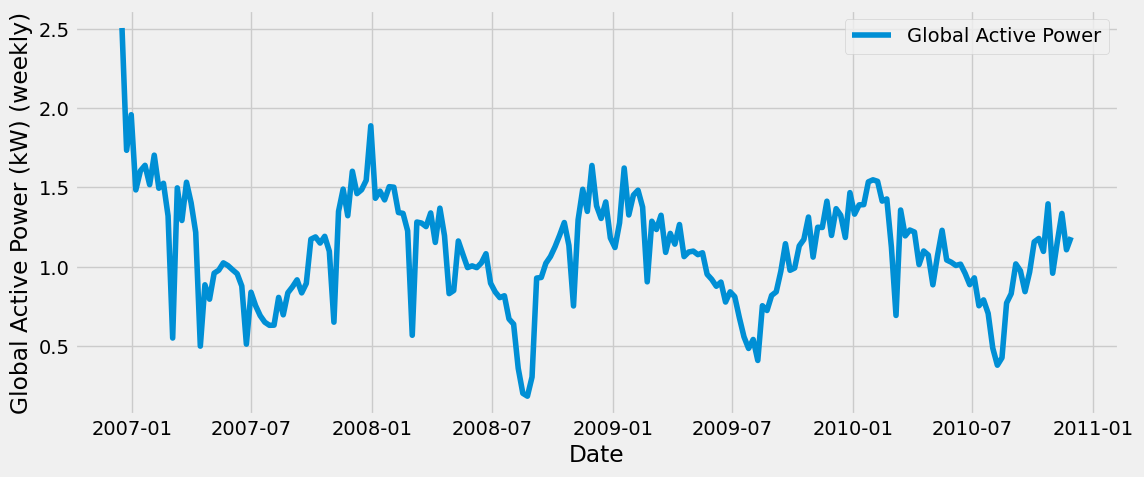

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(df_resampled.index, df_resampled['Global_active_power'], label='Global Active Power')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW) (weekly)')
plt.legend()
plt.show()

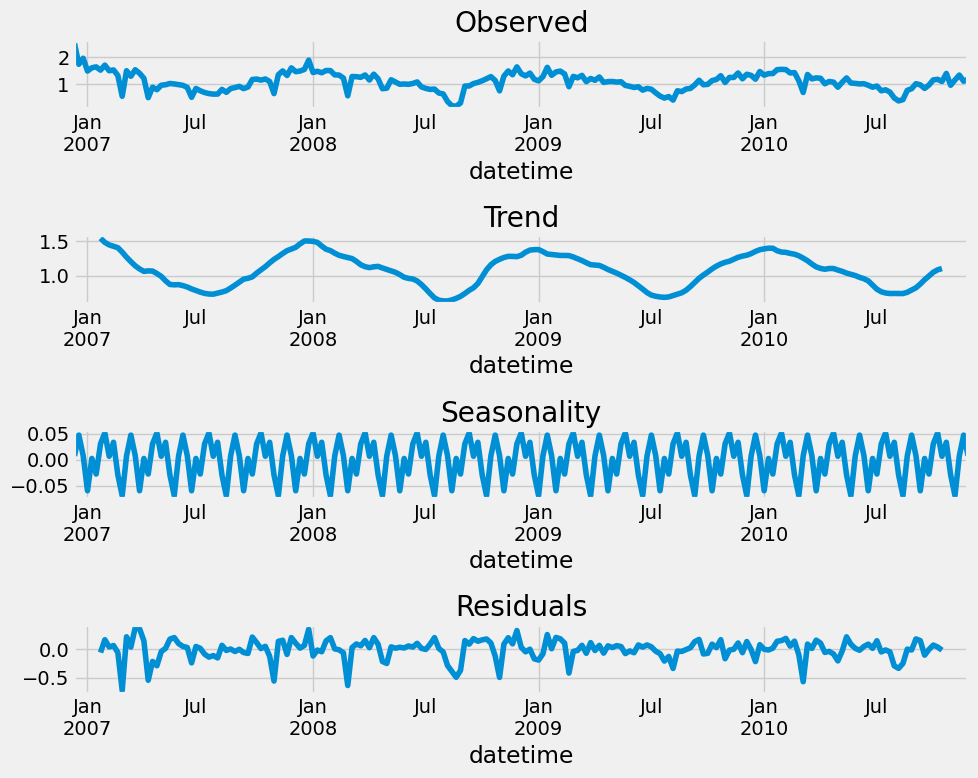

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform decomposition
decomposition = seasonal_decompose(df_resampled['Global_active_power'], model='additive', period=12)

# Plot components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

decomposition.observed.plot(ax=ax1, legend=False, title='Observed')
decomposition.trend.plot(ax=ax2, legend=False, title='Trend')
decomposition.seasonal.plot(ax=ax3, legend=False, title='Seasonality')
decomposition.resid.plot(ax=ax4, legend=False, title='Residuals')

plt.tight_layout()
plt.show()


The data seems seasonal and thus not stationary, no clear upward or downward trend is present.

## Autocorrelation study

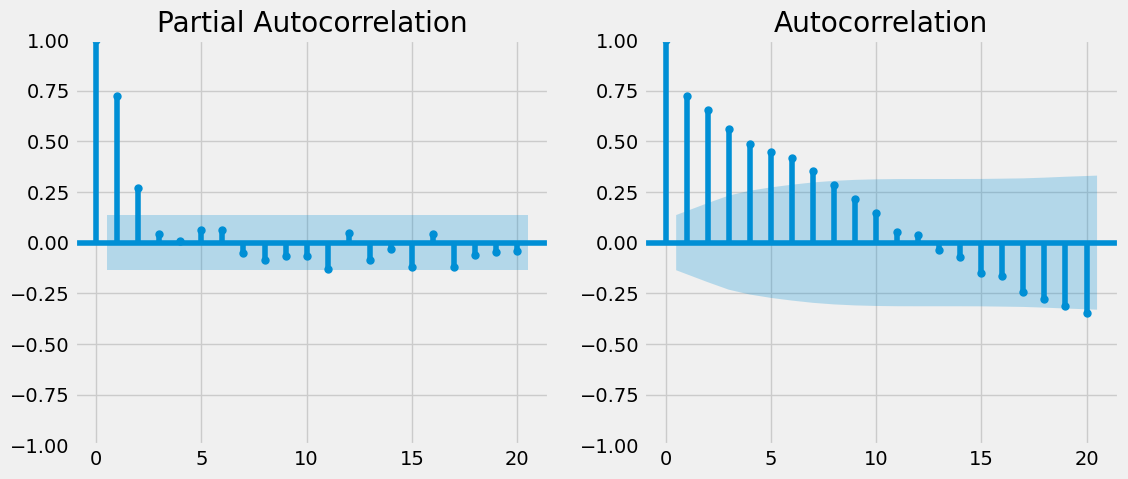

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_pacf(df_resampled['Global_active_power'].dropna(), lags=20, ax=plt.gca())  # PACF plot
plt.subplot(122)
plot_acf(df_resampled['Global_active_power'].dropna(), lags=20, ax=plt.gca())  # ACF plot
plt.show()

## Using SARIMAX model

In [ ]:
# Step 1: Split Data
train_size = int(len(df_resampled) * 0.8)  # 80% train, 20% test
train, test = df_resampled.iloc[:train_size], df_resampled.iloc[train_size:]

# Step 2: AutoSARIMA to Find Best Parameters
auto_sarima_model = auto_arima(
    train['Global_active_power'],
    seasonal=True,  
    m=50,  # 50 (approx.) is the number of weeks in a year (the data is 1 year seasoned).
    start_p=0, max_p=3,
    start_q=0, max_q=8,
    start_P=0, max_P=5,
    start_Q=0, max_Q=5,
    d=1, D=1,  
    trace=True,
    # suppress_warnings=True,
    stepwise=True,
)

# Extract Best Parameters
best_order = auto_sarima_model.order
best_seasonal_order = auto_sarima_model.seasonal_order
print(f"Best SARIMA Order: {best_order}, Seasonal Order: {best_seasonal_order}")


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[50]             : AIC=80.340, Time=0.14 sec
 ARIMA(1,1,0)(1,1,0)[50]             : AIC=49.390, Time=5.95 sec
 ARIMA(0,1,1)(0,1,1)[50]             : AIC=43.358, Time=10.05 sec
 ARIMA(0,1,1)(0,1,0)[50]             : AIC=59.000, Time=0.32 sec
 ARIMA(0,1,1)(1,1,1)[50]             : AIC=44.399, Time=12.83 sec
 ARIMA(0,1,1)(0,1,2)[50]             : AIC=44.399, Time=18.25 sec
 ARIMA(0,1,1)(1,1,0)[50]             : AIC=42.557, Time=8.68 sec
 ARIMA(0,1,1)(2,1,0)[50]             : AIC=44.399, Time=17.88 sec
 ARIMA(0,1,1)(2,1,1)[50]             : AIC=46.399, Time=18.44 sec
 ARIMA(0,1,0)(1,1,0)[50]             : AIC=64.207, Time=4.45 sec
 ARIMA(1,1,1)(1,1,0)[50]             : AIC=inf, Time=35.67 sec
 ARIMA(0,1,2)(1,1,0)[50]             : AIC=41.110, Time=12.15 sec
 ARIMA(0,1,2)(0,1,0)[50]             : AIC=inf, Time=0.87 sec
 ARIMA(0,1,2)(2,1,0)[50]             : AIC=43.108, Time=24.47 sec
 ARIMA(0,1,2)(1,1,1)[50]             : AIC=43

(0, 1, 3) (1, 1, 0, 50)
datetime
2010-02-14    1.413845
2010-02-21    1.427403
2010-02-28    1.123678
2010-03-07    0.692982
2010-03-14    1.357746
Freq: W-SUN, Name: Global_active_power, dtype: float64


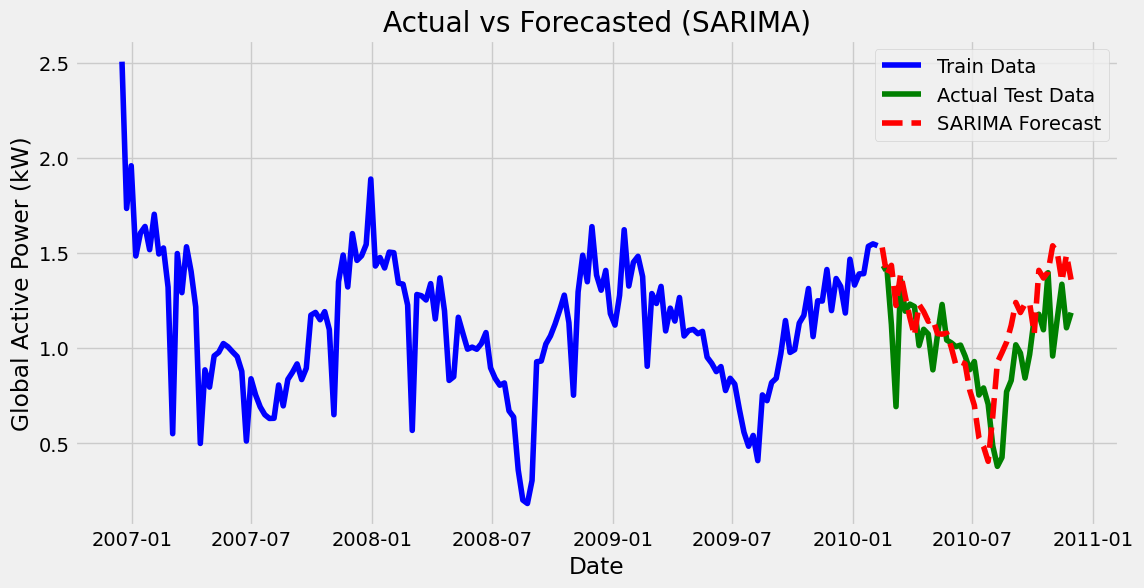

MAE: 0.2043
RMSE: 0.2568


In [16]:
# Some values I tried 
# best_order, best_seasonal_order = (1, 0, 0), (1, 1, 0, 50)   #MAE: 0.1913    RMSE: 0.2266
# best_order, best_seasonal_order = (0, 1, 3), (1, 1, 0, 50) #MAE: 0.2043   RMSE: 0.2568
# best_order, best_seasonal_order = (2, 1, 0), (1, 1, 0, 50)  # MAE: 0.4629  RMSE: 0.5190


print(best_order, best_seasonal_order)
# Step 3: Train SARIMA Model
sarima_model = SARIMAX(
    train['Global_active_power'],
    order=best_order,
    seasonal_order=best_seasonal_order
)

model_fit = sarima_model.fit()

# Step 4: Forecast on Test Set
forecast = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)


# Step 5: Plot Actual vs Forecasted Values
print(test['Global_active_power'].head())
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Global_active_power'], label='Train Data', color='blue')
plt.plot(test.index, test['Global_active_power'], label='Actual Test Data', color='green')
plt.plot(test.index, forecast, label='SARIMA Forecast', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.title('Actual vs Forecasted (SARIMA)')
plt.legend()
plt.show()



# Step 6: Evaluate Performance
mae = mean_absolute_error(test['Global_active_power'], forecast)
rmse = np.sqrt(mean_squared_error(test['Global_active_power'], forecast))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

### Forecasting the next year

In [24]:
best_order, best_seasonal_order = (0, 1, 3), (1, 1, 0, 50)

# Train SARIMA with best orders
model = SARIMAX(df_resampled['Global_active_power'], 
                order=best_order, 
                seasonal_order=best_seasonal_order) 

model_fit = model.fit()

# Print model summary
print(model_fit.summary())


                                      SARIMAX Results                                      
Dep. Variable:                 Global_active_power   No. Observations:                  207
Model:             SARIMAX(0, 1, 3)x(1, 1, [], 50)   Log Likelihood                  -9.698
Date:                             Mon, 24 Mar 2025   AIC                             29.396
Time:                                     00:49:52   BIC                             44.645
Sample:                                 12-17-2006   HQIC                            35.590
                                      - 11-28-2010                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6360      0.202     -3.155      0.002      -1.031      -0.241
ma.L2         -0.2025      

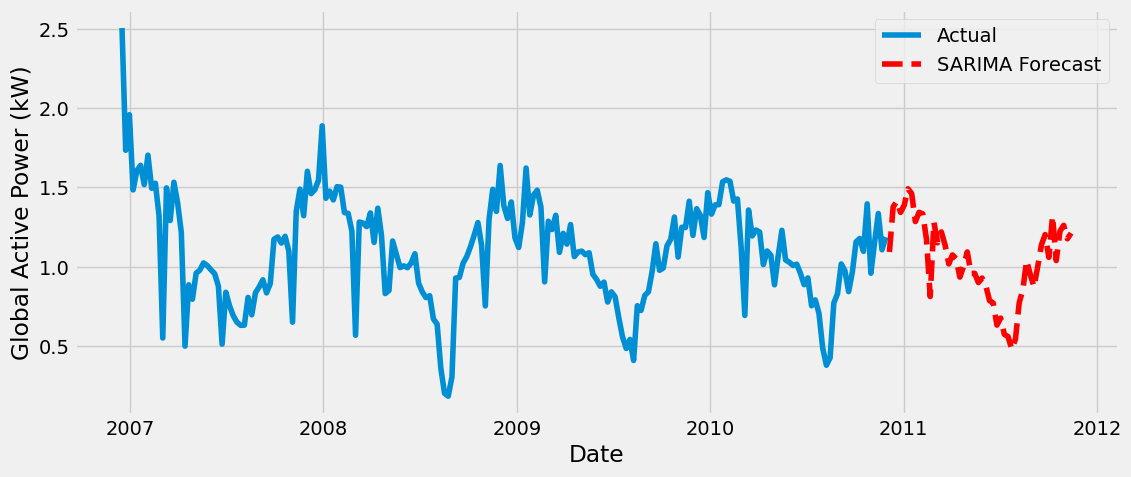

In [25]:
forecast_steps = 50  # Predict next 24 units
forecast = model_fit.forecast(steps=forecast_steps)

# print(forecast)
# Create forecast date range
forecast_index = pd.date_range(start=df_resampled.index[-1], periods=forecast_steps + 1, freq='W')[1:]

# Convert to DataFrame
forecast_df = pd.DataFrame({'Forecast': forecast}, index=forecast_index)

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(df_resampled.index, df_resampled['Global_active_power'], label='Actual')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='SARIMA Forecast', linestyle='dashed', color='red')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()
